In [1]:
#!pip install openai
#!pip install tiktoken
#!pip install pymupdf
#!pip install "unstructured[all-docs]"
#!pip install tesseract
#! apt install tesseract-ocr
#! apt install libtesseract-dev

In [2]:
#Libraries to be installed
#!sudo apt-get update
#!apt-get install poppler-utils

## 2.1 Extracting Information For Document Comprehension

### Extracting using PyMuPDF

In [2]:
import requests
import fitz
import io

url = "https://s2.q4cdn.com/299287126/files/doc_financials/2023/q1/Q1-2023-Amazon-Earnings-Release.pdf"
request = requests.get(url)
filestream = io.BytesIO(request.content)
with fitz.open(stream=filestream, filetype="pdf") as doc:
    text = ""
    for page in doc:
        text += page.get_text()
print(text[:10])

AMAZON.COM


### Extracting using unstructured.io

In [3]:
!wget https://s2.q4cdn.com/299287126/files/doc_financials/2023/q1/Q1-2023-Amazon-Earnings-Release.pdf

--2024-04-24 01:24:23--  https://s2.q4cdn.com/299287126/files/doc_financials/2023/q1/Q1-2023-Amazon-Earnings-Release.pdf
Resolving s2.q4cdn.com (s2.q4cdn.com)... 185.172.149.132, 2a0b:4d07:201::1
Connecting to s2.q4cdn.com (s2.q4cdn.com)|185.172.149.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 283958 (277K) [application/pdf]
Saving to: ‘Q1-2023-Amazon-Earnings-Release.pdf’

Q1-2023-Amazon-Earn 100%[===================>] 277.30K  --.-KB/s    in 0.05s   

2024-04-24 01:24:23 (5.06 MB/s) - ‘Q1-2023-Amazon-Earnings-Release.pdf’ saved [283958/283958]



In [6]:
from unstructured.partition.pdf import partition_pdf
strategy = "hi_res" # Strategy for analyzing PDFs and extracting table structure
model_name = "yolox" # Best model for table extraction. Other options are detectron2_onnx and chipper depending on file layout
# Extracts the elements from the PDF
elements = partition_pdf(filename="/content/Q1-2023-Amazon-Earnings-Release.pdf",
strategy=strategy,model_name = model_name,
infer_table_structure=True
)


config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
from unstructured.staging.base import elements_to_json
import os
elements_to_json(elements, filename=f"/content/Q1-2023-Amazon-Earnings-Release.json")

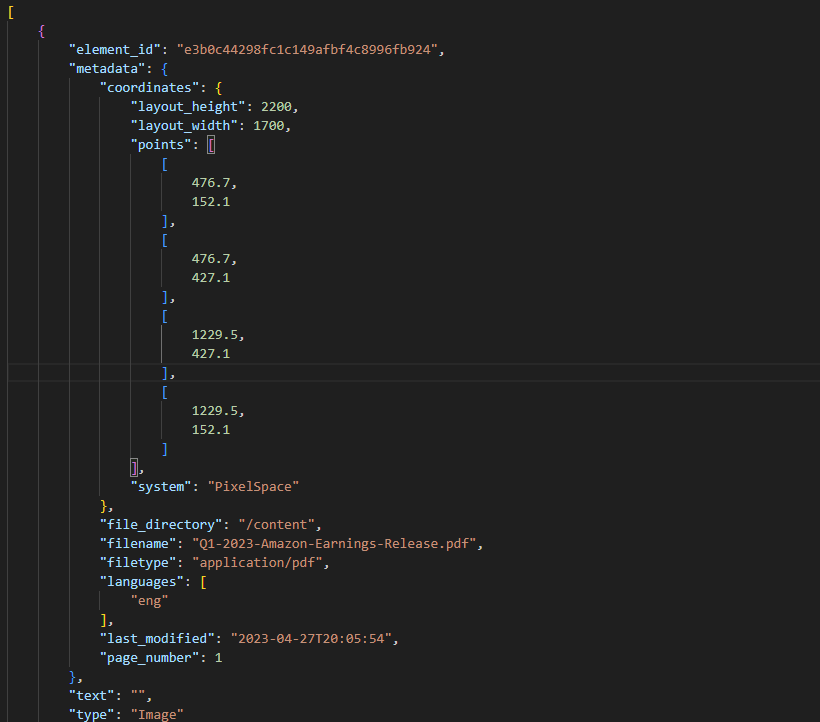

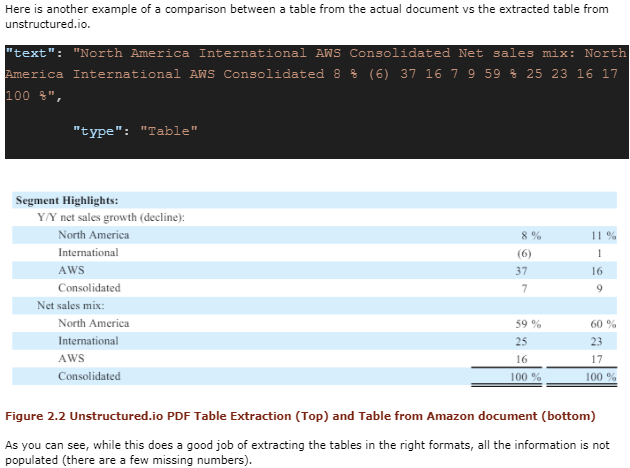

## Context Retrieval

### Keyword Based Retrieval

In [1]:
!pip install rank_bm25


In [3]:
from rank_bm25 import BM25Okapi

corpus = [
    "Hello there how are you!",
    "It is quite windy in Boston",
    "How is the weather tomorrow?"
]

tokenized_corpus = [doc.split(" ") for doc in corpus]

bm25 = BM25Okapi(tokenized_corpus)

In [4]:
query = "windy day"
tokenized_query = query.split(" ")

doc_scores = bm25.get_scores(tokenized_query)

In [5]:
doc_scores

array([0.        , 0.48362189, 0.        ])

### Embeddings Based Retrieval